# A quick starrotate tutorial: measuring the rotation period of a TESS star

In this tutorial we'll measure the rotation period of a TESS target. First we'll download and plot a light curve using the lightkurve package.

In [1]:
import lightkurve as lk

starname = "TIC 10863087"
lcf = lk.search_lightcurvefile(starname).download()

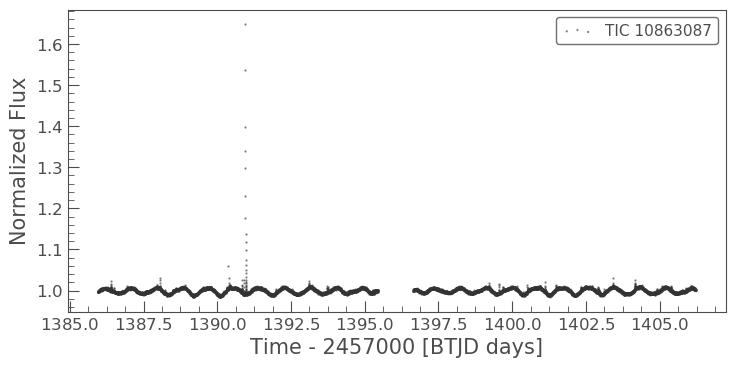

In [2]:
lc = lcf.PDCSAP_FLUX
lc.scatter(alpha=.5, s=.5);

First of all, let's remove the flares which will limit our ability to measure a rotation period. Let's also get rid of any NaN values in the light curve.

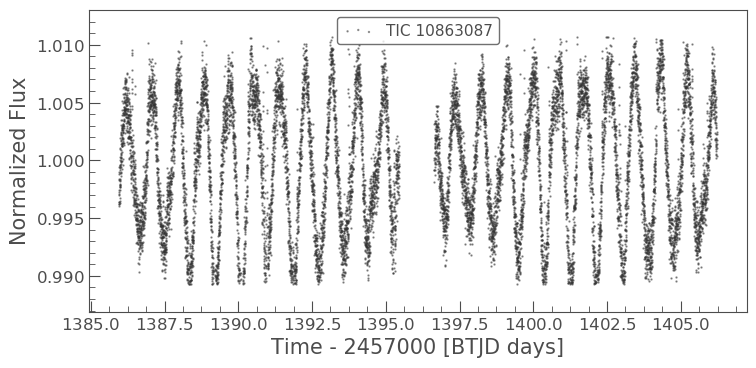

In [3]:
no_nan_lc = lc.remove_nans()
clipped_lc = no_nan_lc.remove_outliers(sigma=2)
clipped_lc.scatter(alpha=.5, s=.5);

Next, let's import starrotate and set up a RotationModel object.

In [4]:
import starrotate as sr

rotate = sr.RotationModel(clipped_lc.time, clipped_lc.flux, clipped_lc.flux_err)

We can also plot the light curve using the plot_lc function in starrotate:

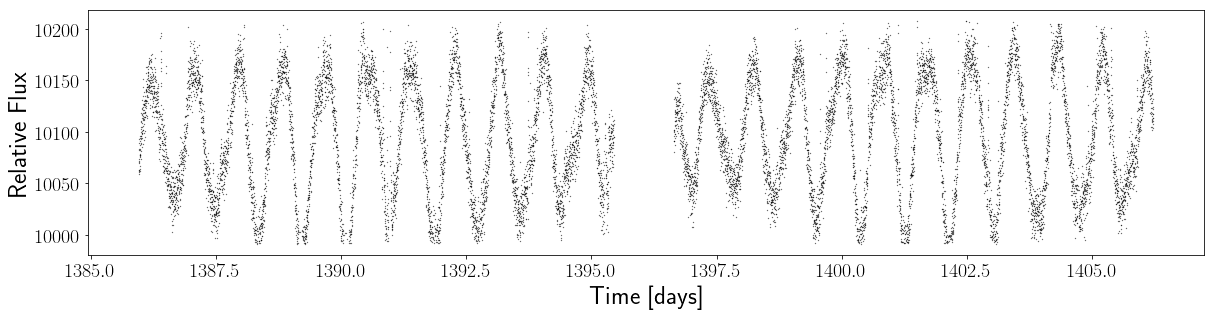

In [5]:
rotate.plot_lc()

Now let's measure a rotation period for this star using the astropy implementation of the Lomb-Scargle periodogram. This algorithm fits a single sinusoid to the light curve and reports the squared amplitude of the sinusoid over a range of frequencies (1/periods).

In [6]:
ls_period = rotate.LS_rotation()

In [7]:
ls_period

0.8608380290365292

We measured a rotation period of 0.86 days by finding the period of the highest peak in the periodogram. Let's plot the periodogram.

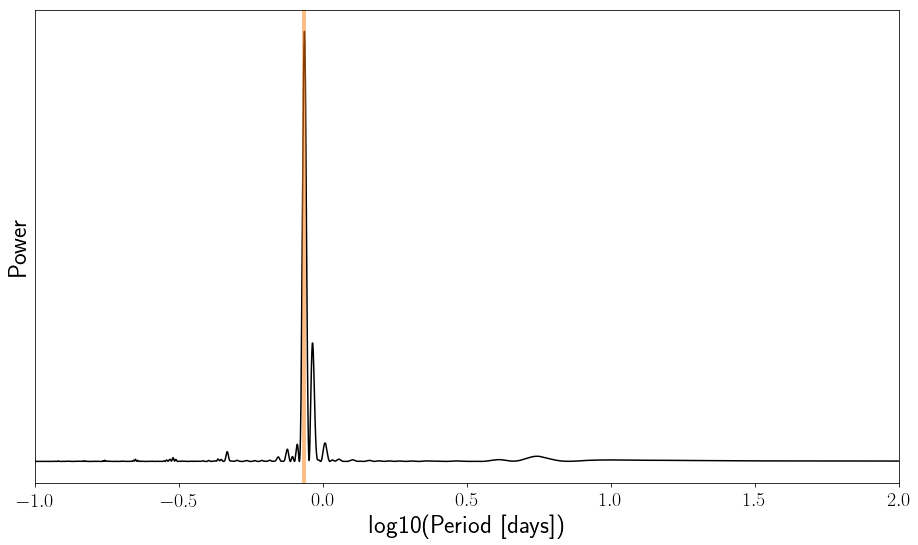

In [8]:
rotate.pgram_plot()

Now let's calculate an ACF and measure a rotation period by finding the highest peak.

In [9]:
tess_cadence = 1./24./30.  # This is a TESS 2 minute cadence star.
acf_period = rotate.ACF_rotation(tess_cadence)

/Users/rangus/projects/starrotate/starrotate/rotation_tools.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


In [10]:
acf_period

0.8763888888888888

This method estimates a period of 0.88 days, which is very close to the periodogram method. It is important to note that the LS periodogram method and the ACF method are not independent, i.e. if you measure a certain rotation period with one, you are likely to measure the same rotation period with the other. These two methods should not be used as independent 'checks' to validate a measured rotation period. 

Finally, let's measure a rotation period with the exoplanet implementation of a celerite Gaussian process. This part takes a little while to run.

In [11]:
gp_results = rotate.GP_rotation()

success: False
initial logp: -54886.575693444596
final logp: -53829.8979901813
sampling...


Sampling 4 chains: 100%|██████████| 208/208 [00:13<00:00,  7.44draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logs2, mean]
Sampling 4 chains:  54%|█████▍    | 4303/8000 [02:08<01:50, 33.49draws/s]
The number of effective samples is smaller than 25% for some parameters.


We can print the resulting GP rotation period and its associated uncertainties:

In [12]:
print("GP period = {0:.2f} + {1:.2f} - {2:.2f}".format(rotate.gp_period, rotate.errp, rotate.errm))

GP period = 0.81 + 0.02 - 0.02


And plot the posterior PDF:

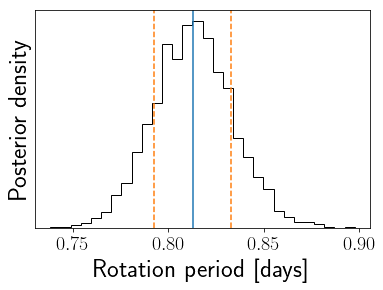

In [13]:
rotate.plot_posterior()

We can also plot this manually:

Text(0, 0.5, 'Unnormalized probability')

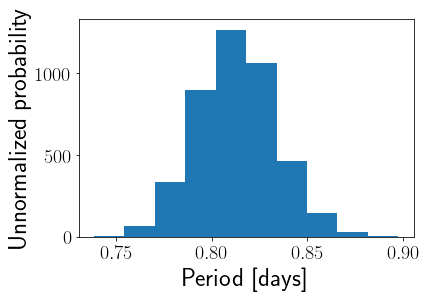

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(rotate.period_samples);
plt.xlabel("Period [days]")
plt.ylabel("Unnormalized probability")

And we can plot the posterior prediction:

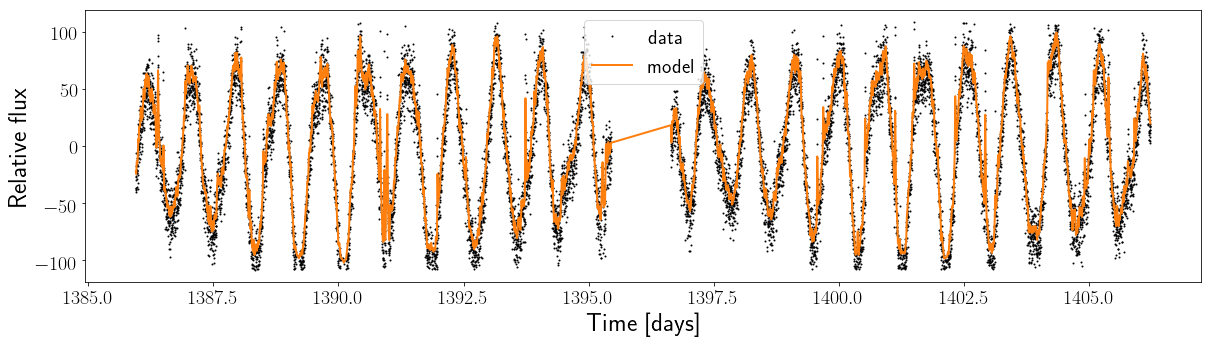

In [15]:
rotate.plot_prediction()

You can see that there are still outliers in the light curve produced by flares which is affecting the GP fit. A better outlier removal algorithm would improve this fit!